In [1]:
import sys
sys.path.append("../helper_functions")
import duneapi_utils as d
import l2beat_utils as ltwo
sys.path.pop()

import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# # Get token classification
# # https://dune.com/queries/3852319
token_df = d.get_dune_data(query_id = 3852319,
    name = "tokens_by_type_base_opm",
    num_hours_to_rerun=0
)

token_df.sample(5)

2024-06-21 17:28:49.504 | INFO     | duneapi_utils:get_dune_data:58 - Results available at https://dune.com/queries/3852319
2024-06-21 17:28:56,032 INFO dune_client.base_client executing 3852319 on medium cluster
2024-06-21 17:28:56,975 INFO dune_client.base_client waiting for query execution 01J0YB7MWMHR3X3Z76JF2G85MB to complete: ExecutionState.PENDING (queue position: 1)
2024-06-21 17:29:02,440 INFO dune_client.base_client waiting for query execution 01J0YB7MWMHR3X3Z76JF2G85MB to complete: ExecutionState.EXECUTING
2024-06-21 17:29:08,062 INFO dune_client.base_client waiting for query execution 01J0YB7MWMHR3X3Z76JF2G85MB to complete: ExecutionState.EXECUTING
2024-06-21 17:29:13,534 INFO dune_client.base_client waiting for query execution 01J0YB7MWMHR3X3Z76JF2G85MB to complete: ExecutionState.EXECUTING
2024-06-21 17:29:19,009 INFO dune_client.base_client waiting for query execution 01J0YB7MWMHR3X3Z76JF2G85MB to complete: ExecutionState.EXECUTING
2024-06-21 17:29:24,511 INFO dune_clien

,blockchain,chain_id,factory_address,l1_token,symbol,token_address,token_classification,last_updated
281365,base,8453,None,None,ETF-ETH,0x753b440c791977b15e85615987af6c7466bfaa31,Not Proxy or Factory,2024-06-21 21:28:56.468913
53165,base,8453,None,None,BMT,0xbeaaa4bec3b3c735e0ba4502831b9242cd80e091,Not Proxy or Factory,2024-06-21 21:28:56.468913
6699,base,8453,None,None,KEK,0xe83d5f686b0397f306baa098410ac69f680cd756,Not Proxy or Factory,2024-06-21 21:28:56.468913
13942,base,8453,None,None,None,0xfc9e367e4ddc9d6b31364c4e58d05d5b3f64ed82,Not Proxy or Factory,2024-06-21 21:28:56.468913
89844,base,8453,None,None,Dawkins,0x22ae8ac2e3408fda838e3abf0c5f874ae9d0ac29,Not Proxy or Factory,2024-06-21 21:28:56.468913


In [3]:
# Get Lastest L2B AOP
l2b_df = ltwo.get_daily_aop_by_token()
l2b_df_spc = l2b_df[l2b_df['project'].isin(['optimism','base'])]
l2b_df_spc = l2b_df_spc.rename(columns={'project':'blockchain'})

l2b_df_spc = l2b_df_spc[['dt','blockchain','token_type','asset_id','address','usd_value']]
l2b_df_spc['address'] = l2b_df_spc['address'].str.lower()

l2b_df_spc.sample(5)

,dt,blockchain,token_type,asset_id,address,usd_value
746,2024-06-21,optimism,canonical,matic-matic-token,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,3.139700e+02
249,2024-06-21,base,canonical,arpa-arpa-token,0xba50933c268f567bdc86e1ac131be072c6b0b71a,6.198130e+03
253,2024-06-21,base,canonical,dola-dola-usd-stablecoin,0x865377367054516e17014ccded1e7d814edc9ce4,6.989388e+07
256,2024-06-21,base,external,base:sdex-smardex,0xfd4330b0312fdeec6d4225075b82e00493ff2e3f,2.417467e+06
784,2024-06-21,optimism,canonical,pt-phemex-token,0xbbb32f99e6f2cb29337eebaa43c5069386de6e6c,1.697008e+08


In [4]:
cols = ['blockchain','token_address','l1_token','token_classification','symbol']
token_if_l1_df = token_df[cols].rename(columns={'l1_token':'address'})
token_if_l2_df = token_df[cols].rename(columns={'token_address':'address'})

token_if_l2_df.sample(5)

,blockchain,address,l1_token,token_classification,symbol
225037,base,0x103f8131e6c0e7a5fb2bdd337ae754a71976226f,None,Not Proxy or Factory,BaseGrow
236657,base,0x36c5b446216e66ef7ed7b91ccba6306593fefb88,None,Not Proxy or Factory,CHAD
312776,base,0x6d5cc96f07e2e84dfc60b6bfa47e62c05b91c6f4,None,Not Proxy or Factory,LSD7
83314,base,0x68575e03ce2511d602ee7838048890a412745c8f,None,Not Proxy or Factory,T2024
157128,base,0x42305f3796c8a1c9ad381d38ed5093262efc1aeb,None,Not Proxy or Factory,ZERG


In [24]:
unified_df = l2b_df_spc.merge(token_if_l1_df[['blockchain','address','token_classification']]
                              , on=['blockchain','address'], how='left')
unified_df = unified_df.merge(token_if_l2_df[['blockchain','address','token_classification']]
                              , on=['blockchain','address'], how='left')

In [25]:
unified_df['token_classification'] = unified_df['token_classification_x'].fillna(unified_df['token_classification_y']).fillna('Unknown')
unified_df = unified_df.drop(columns=['token_classification_x', 'token_classification_y'])

In [26]:
#Drop dupes where 1 L1 maps to multiple L2 tokens
unified_df = unified_df.drop_duplicates(keep='first')
unified_df.to_csv('csv_outputs/aop_by_chain_token_classification.csv')

In [27]:
unified_df.sample(5)

,dt,blockchain,token_type,asset_id,address,usd_value,token_classification
178,2024-06-21,optimism,native,optimism:extra-extra-finance,0x2dad3a13ef0c6366220f989157009e501e7938f8,1.672888e+07,Not Proxy or Factory
0,2024-06-21,base,canonical,omi-omi-token,0xed35af169af46a02ee13b9d79eb57d6d68c1749e,7.239369e+05,Immutable Factory Created
71,2024-06-21,base,native,base:usdc-usd-coin,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,3.055301e+09,Immutable Factory Created
108,2024-06-21,optimism,canonical,han-hanchain,0x0c90c57aaf95a3a87eadda6ec3974c99d786511f,1.014424e+07,Immutable Factory Created
172,2024-06-21,optimism,native,optimism:kite-protocol-token,0xf467c7d5a4a9c4687ffc7986ac6ad5a4c81e1404,4.340070e+06,Not Proxy or Factory


In [32]:
grouped_df = unified_df.groupby(['blockchain', 'token_type', 'token_classification'])['usd_value'].sum().reset_index()

# Calculate the total usd_value for each blockchain
total_by_blockchain = grouped_df.groupby('blockchain')['usd_value'].sum().reset_index()
total_by_blockchain = total_by_blockchain.rename(columns={'usd_value': 'total_usd_value_by_blockchain'})
# Merge the total_by_blockchain back into the grouped_df
grouped_df = grouped_df.merge(total_by_blockchain, on='blockchain')
# Calculate the overall total usd_value
overall_total = grouped_df['usd_value'].sum()
# Add new columns for the percentages
grouped_df['percent_of_blockchain'] = (grouped_df['usd_value'] / grouped_df['total_usd_value_by_blockchain']) * 100
grouped_df['percent_of_overall'] = (grouped_df['usd_value'] / overall_total) * 100
# Drop the total_usd_value_by_blockchain column as it's no longer needed
grouped_df = grouped_df.drop(columns=['total_usd_value_by_blockchain'])
# Display the updated DataFrame
# print(grouped_df)
# # Display the grouped table
grouped_df.sort_values(by='usd_value',ascending=False)

,blockchain,token_type,token_classification,usd_value,percent_of_blockchain_total,percent_of_overall_total
4,base,native,Immutable Factory Created,3.055301e+09,42.123488,21.935411
14,optimism,native,Not Proxy or Factory,2.260107e+09,33.857135,16.226350
8,optimism,canonical,Immutable Factory Created,2.184766e+09,32.728501,15.685441
10,optimism,canonical,Unknown,2.049008e+09,30.694805,14.710773
5,base,native,Not Proxy or Factory,2.003082e+09,27.616526,14.381047
1,base,canonical,Unknown,1.904385e+09,26.255794,13.672458
15,optimism,native,Proxy,1.723192e+08,2.581397,1.237159
0,base,canonical,Immutable Factory Created,1.546984e+08,2.132830,1.110651
7,base,native,Unknown,7.421847e+07,1.023251,0.532849
6,base,native,Proxy,4.565445e+07,0.629439,0.327774


<Figure size 2000x1500 with 0 Axes>

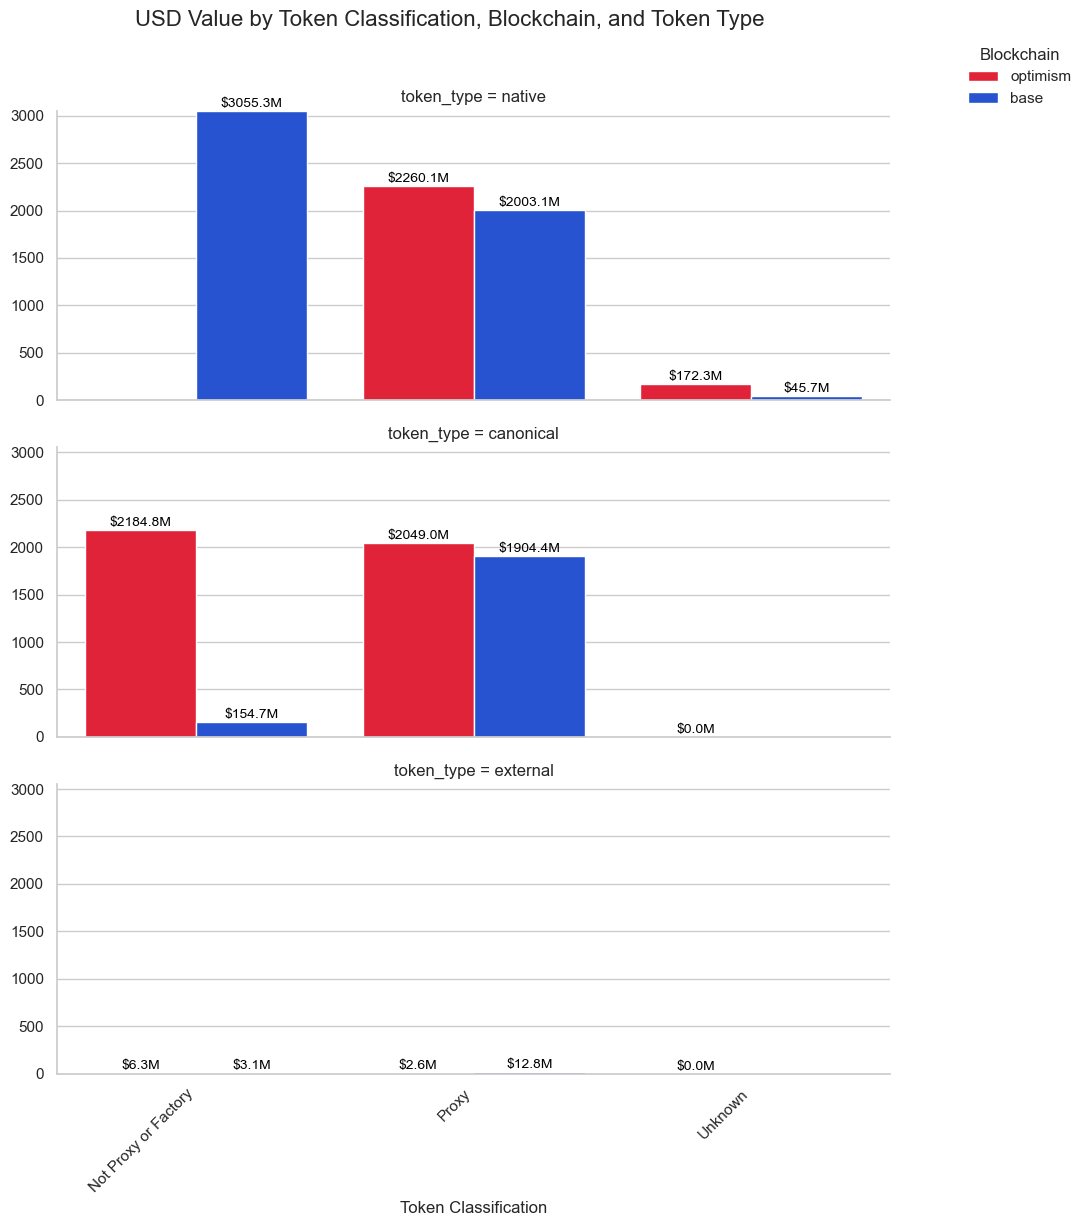

In [29]:
# Convert usd_value to millions
grouped_df['usd_value_millions'] = grouped_df['usd_value'] / 1e6

# Set the order of token_type
token_type_order = ['native', 'canonical', 'external']
grouped_df['token_type'] = pd.Categorical(grouped_df['token_type'], categories=token_type_order, ordered=True)

# Set the style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(20, 5 * len(token_type_order)))

# Create a custom color palette
color_palette = {'optimism': '#ff0420', 'base': '#0b45ed'}

# Create the faceted bar chart
g = sns.FacetGrid(grouped_df, row="token_type", height=4, aspect=2, sharex=True, sharey=True)

# Define the plotting function
def plot_bars(data, **kwargs):
    ax = sns.barplot(x="token_classification", y="usd_value_millions", hue="blockchain", data=data, 
                     palette=color_palette, hue_order=['optimism', 'base'], **kwargs)
    for p in ax.patches:
        ax.annotate(f'${p.get_height():.1f}M', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("USD Value (Millions)")

# Apply the plotting function to each facet
g.map_dataframe(plot_bars)

# Adjust the y-axis to be the same for all facets
y_max = grouped_df['usd_value_millions'].max()
g.set(ylim=(0, y_max))

# Add labels and title
g.set_axis_labels("Token Classification", "")
g.fig.suptitle("USD Value by Token Classification, Blockchain, and Token Type", fontsize=16, y=1.02)

# Adjust the legend
g.add_legend(title="Blockchain", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()